## Proyecto NLP: Análisis de sentimientos

### 1. Etapa de Descarga y EDA

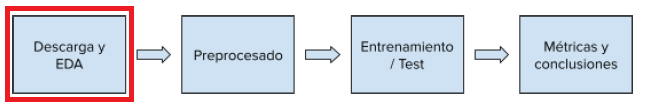

#### 1.1 Instalamos librerias necesarias

In [2]:
!pip install unzip
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.1 MB/s eta 0:00:00
  Created wheel for pyDAWG: filename=pyDAWG-1.0.1-cp310-cp310-linux_x86_64.whl size=62201 sha256=333d628a0ba97c3af0fbed03c059319b84443526ff444abb4ef01736b4004aa1
  Stored in directory: /root/.cache/pip/wheels/15/5a/ec/7dfb31587fa2fee403d96efdb4ba07a1f85fb1aedf74c97da5
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=65458f6bc8b805d378546bfc5faaa7f13b78960355e14263b8d2cc3b91121cbf
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for 

#### 1.2 Descarga del dataset: Amazon Reviews 2018, sub-set Video_Games_5

In [3]:
!unzip Video_Games_5.zip

Archive:  Video_Games_5.zip
  inflating: Video_Games_5.json      


In [4]:
import pandas as pd

In [6]:
# Carga del dataset
df = pd.read_json('./Video_Games_5.json', lines=True)
df.shape


(497577, 12)

#### 1.3 Análisis exploratorio de los datos

##### 1.3.0 Filtrado / Reducción inicial del dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         497577 non-null  int64 
 1   verified        497577 non-null  bool  
 2   reviewTime      497577 non-null  object
 3   reviewerID      497577 non-null  object
 4   asin            497577 non-null  object
 5   reviewerName    497501 non-null  object
 6   reviewText      497419 non-null  object
 7   summary         497468 non-null  object
 8   unixReviewTime  497577 non-null  int64 
 9   vote            107793 non-null  object
 10  style           289237 non-null  object
 11  image           3634 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 42.2+ MB


In [8]:
# Me quedo solo con las columnas de interes para el análisis del corpus ('overall', 'reviewText')
df = df.drop(columns= [
'verified', 'reviewTime',	'reviewerID',	'asin', 'reviewerName',	'summary',	'unixReviewTime',	'vote', 'style', 'image'])
df.shape

(497577, 2)

In [9]:
df.head()

,overall,reviewText
0,5,"This game is a bit hard to get the hang of, bu..."
1,4,I played it a while but it was alright. The st...
2,3,ok game.
3,2,"found the game a bit too complicated, not what..."
4,5,"great game, I love it and have played it since..."


In [12]:
# Eliminar los registros con valor faltante o nulo en el atributo 'reviewText' porque no podriamos estudiarlo en nuestro analisis de sentimiento
df = df.dropna(subset=['reviewText'])
df.shape

(497419, 2)

overall
5    299623
4     93644
3     49140
1     30879
2     24133
Name: count, dtype: int64


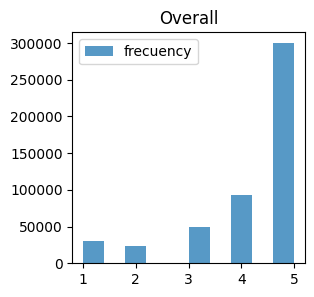

In [14]:
# Ver la distribución de los reviews según su clasificación del 1-5

import matplotlib.pyplot as plt

print(df['overall'].value_counts())

plt.figure(figsize=(3,3))
plt.hist(df.loc[:,'overall'],density=0, alpha=0.75, label='frecuency')
plt.legend()
plt.title('Overall')
plt.show()

In [15]:
# El dataset de Amazon es muy grande (~500.000 records) y esta desbalanceado
# Crear una funcion para obtener un subconjunto mas pequeno y balanceado a nivel de la columna objetivo (overall)

def balanced_subset(df, column, num_samples):
    categories_group = df.groupby(column)
    samples = []

    for group_name, group in categories_group:
        sampled_group = group.sample(n=num_samples, random_state=42) # Iterar los grupos con muestras aleatorios
        samples.append(sampled_group)

    balanced_df = pd.concat(samples)
    return balanced_df

In [16]:
# Nuevo subset balanceado, 2000 muestras por cada nivel de clasificacion de los reviews
balanced_df = balanced_subset(df, 'overall', 2000)
balanced_df.reset_index(drop=True, inplace=True)
print(balanced_df['overall'].value_counts())

overall
1    2000
2    2000
3    2000
4    2000
5    2000
Name: count, dtype: int64


In [17]:
balanced_df

,overall,reviewText
0,1,Made in china... either a single bad luck of t...
1,1,"Having played all of the other games, I was so..."
2,1,"Macro buttons in the way (obviously?), can't l..."
3,1,"Just received my ""Cronusmax Plus"" and after so..."
4,1,"Not worth the learning curve, the nunchuck+wii..."
...,...,...
9995,5,Super Smash Bros. for the Nintendo 64 is one o...
9996,5,This controller has saved us a fortune in batt...
9997,5,My kids love this game.
9998,5,This game is great. Network is much better tha...


##### 1.3.1 Cardinalidad del vocabulario del corpus

In [18]:
# Crear el corpus concatenando todos los reviews

corpus = balanced_df['reviewText'].str.cat(sep='')

In [19]:
corpus

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Tamaño del corpus

print(len(corpus))

8472808


In [22]:
# Tokenizar: Frases dentro de los reviews utilizando metodos de string de Python

sentences = corpus.split('.')
print(sentences)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
# Revisar una frase
sentence = sentences[5]
print(sentence)

  Might be better to buy it in person somewhere that will stand behind an in person warranty exchange after 30 days if there are still places that do


In [24]:
# Calcular la cardinalidad del vocabulario

unique_words = set(sentences)
vocabulary_cardinality = len(unique_words)
print("Cardinalidad de vocabulario:", vocabulary_cardinality)

Cardinalidad de vocabulario: 87117


##### 1.3.2 Distribución de reviews

In [25]:
# Crear una variable 'level_sentiment' de tipo binario que convierta la clasificacion a nivel de estrellas (1-5) en solo 2 categorias (negativo/positivo)

def label_sentiment(row):
    if int(row['overall']) <= 3:
        return 0
    else:
        return 1

In [26]:
balanced_df['sentiment_label'] = balanced_df.apply(lambda row: label_sentiment(row), axis=1)

In [27]:
balanced_df

,overall,reviewText,sentiment_label
0,1,Made in china... either a single bad luck of t...,0
1,1,"Having played all of the other games, I was so...",0
2,1,"Macro buttons in the way (obviously?), can't l...",0
3,1,"Just received my ""Cronusmax Plus"" and after so...",0
4,1,"Not worth the learning curve, the nunchuck+wii...",0
...,...,...,...
9995,5,Super Smash Bros. for the Nintendo 64 is one o...,1
9996,5,This controller has saved us a fortune in batt...,1
9997,5,My kids love this game.,1
9998,5,This game is great. Network is much better tha...,1


In [28]:
# Salvar el nuevo dataset balanceado con la clasificación de sentimiento
balanced_df.to_csv('./balanced_df.csv', index=False)

##### 1.3.3 Números de reviews positivos y negativos

In [29]:
# Contar reviews positivos y negativos
count_positive = balanced_df[balanced_df['sentiment_label'] == 1]
count_negative = balanced_df[balanced_df['sentiment_label'] == 0]

print("total de reviews positivos:", count_positive.shape[0])
print("total de reviews negativos:", count_negative.shape[0])

total de reviews positivos: 4000
total de reviews negativos: 6000


##### 1.3.4 N-grams mas frecuentes

In [30]:
from nltk import ngrams
from nltk.probability import FreqDist
from collections import Counter

In [31]:
# Ver primero las palabras más frecuentes

words_count = corpus.lower().split()
wf = Counter(words_count)
wf_most_common = wf.most_common(10)


In [32]:
wf_most_common

[('the', 83534),
 ('to', 41605),
 ('and', 40993),
 ('a', 37620),
 ('of', 28993),
 ('i', 28158),
 ('is', 25876),
 ('you', 24403),
 ('it', 21846),
 ('this', 18215)]

In [33]:
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]

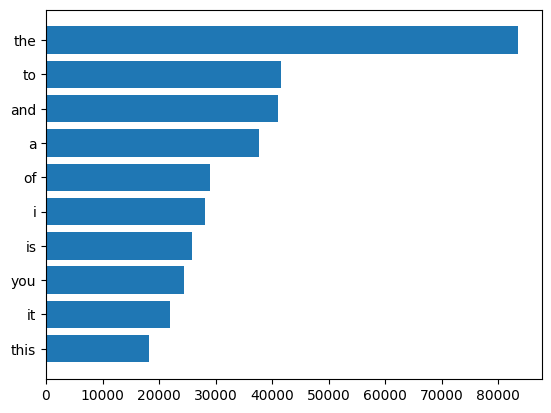

In [34]:
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.show()

In [35]:
# Crear los n-grams utilizando la libreria de NLTK

words_nltk = corpus.lower().split()
bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))

In [36]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

In [37]:
# Obtenerlos Bigrams mas frecuentes

bg_freq.most_common(15)

[(('of', 'the'), 7639),
 (('the', 'game'), 6063),
 (('this', 'game'), 4821),
 (('in', 'the'), 4665),
 (('if', 'you'), 3504),
 (('on', 'the'), 3234),
 (('to', 'the'), 3215),
 (('is', 'a'), 3211),
 (('you', 'can'), 2968),
 (('and', 'the'), 2925),
 (('game', 'is'), 2653),
 (('for', 'the'), 2613),
 (('with', 'the'), 2402),
 (('it', 'is'), 2352),
 (('this', 'is'), 2308)]

In [38]:
# Los Trigrams mas frecuentes

tg_freq.most_common(15)

[(('a', 'lot', 'of'), 1114),
 (('this', 'game', 'is'), 1104),
 (('the', 'game', 'is'), 1014),
 (('you', 'have', 'to'), 899),
 (('one', 'of', 'the'), 721),
 (('of', 'the', 'game'), 625),
 (('this', 'is', 'a'), 581),
 (('some', 'of', 'the'), 513),
 (('the', 'graphics', 'are'), 509),
 (('if', 'you', 'are'), 471),
 (('you', 'want', 'to'), 398),
 (('the', 'fact', 'that'), 390),
 (('if', 'you', 'want'), 386),
 (('in', 'the', 'game'), 376),
 (('most', 'of', 'the'), 368)]

In [39]:
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

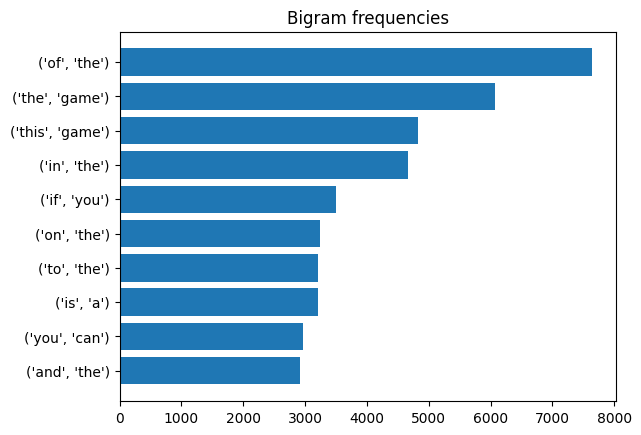

In [40]:
# Pintar los Bigrams y Trigrams
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

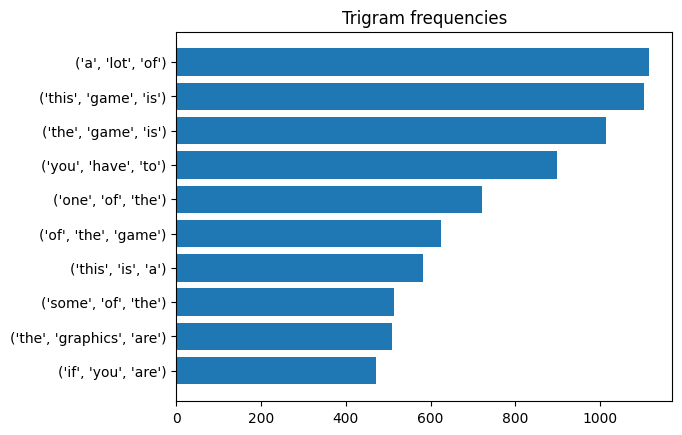

In [41]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

##### 1.3.5 Nube de palabras

In [42]:
from collections import Counter
from wordcloud import WordCloud

In [43]:
# Generar WordCloud
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

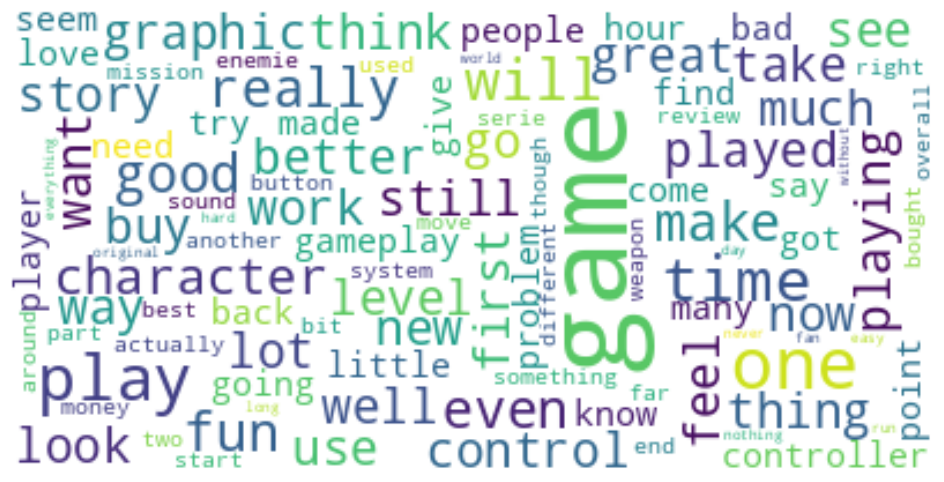

In [44]:
words_list = corpus.lower().strip().split()
plot_word_cloud(words_list)

##### 1.3.6 Visualización

In [45]:
# Cargarotras librerias
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import re
from time import time
from collections import defaultdict

import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [46]:
# Contar el número de cores en el ordenador
cores = multiprocessing.cpu_count()
print (cores)

2


In [47]:
# Definir los parametros para usar el modelo Word2Vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [48]:
# Revisar el tamaño del vocabulario que genera el modelo y su tiempo de ejecución

t = time()
sent = [row.split() for row in balanced_df['reviewText']]
w2v_model.build_vocab(sent, progress_per=10000)

print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))
print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))

Vocabulario compuesto por 5439 palabras
Tiempo para construir el vocabulario: 0.04 mins


In [49]:
# Entrenar el modelo
t = time()

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Tiempo para entrenar el modelo: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para entrenar el modelo: 2.42 mins


In [50]:
# Salvar el modelo
w2v_model.save('./w2v_model.pkl')

In [51]:
# Ejecutar el modelo con las palabras mas frecuentes encontrados en la nube de palabras
w2v_model.wv.most_similar(positive=["game"])

[('game,', 0.49726754426956177),
 ('game.', 0.42210686206817627),
 ('gameplay', 0.4065932333469391),
 ('title', 0.3468371033668518),
 ('games', 0.32901665568351746),
 ('it', 0.32599952816963196),
 ('campaign', 0.3167869746685028),
 ('game...', 0.3110808730125427),
 ('addictive', 0.3063475787639618),
 ('madden', 0.2999417781829834)]

In [52]:
w2v_model.wv.most_similar(positive=["play"])

[('play.', 0.4301043450832367),
 ('playing', 0.42510610818862915),
 ('enjoy', 0.35965415835380554),
 ('played', 0.3532100021839142),
 ('compete', 0.35146239399909973),
 ('connect', 0.3328380882740021),
 ('play,', 0.3298698365688324),
 ('finish', 0.32909587025642395),
 ('join', 0.32535555958747864),
 ('rented', 0.31792086362838745)]

In [53]:
w2v_model.wv.most_similar(positive=["character"])

[("character's", 0.4883931875228882),
 ('character.', 0.43817511200904846),
 ('characters', 0.43753618001937866),
 ('character,', 0.43233755230903625),
 ('crew', 0.38554131984710693),
 ('member', 0.3694097697734833),
 ('weapon.', 0.36306172609329224),
 ('scenario', 0.35888099670410156),
 ('avatar', 0.3555672764778137),
 ('facial', 0.3399699032306671)]

In [54]:
w2v_model.wv.most_similar(positive=["buy"])

[('purchase', 0.5472515821456909),
 ('buy,', 0.5219963788986206),
 ('rent', 0.49550703167915344),
 ('buying', 0.48984116315841675),
 ('buy.', 0.4884125590324402),
 ('afford', 0.48638004064559937),
 ('recomend', 0.474470853805542),
 ('sell', 0.45599186420440674),
 ('payed', 0.4530753791332245),
 ('purchasing', 0.4514390826225281)]

In [55]:
w2v_model.wv.most_similar(positive=["graphic"])

[('graphics', 0.4715614318847656),
 ('resolution', 0.4706588089466095),
 ('texture', 0.4388093650341034),
 ('outdated', 0.4285583198070526),
 ('scenery', 0.42774656414985657),
 ('crisp', 0.4267011284828186),
 ('notch', 0.42218706011772156),
 ('solid,', 0.4195937216281891),
 ('sound', 0.41631054878234863),
 ('Graphically', 0.4093070924282074)]

In [56]:
# Crear clusters de palabras con las 10 palabras más similares a las encontradas con el modelo de Word2Vec

keys = ['play','game','character','buy','graphic']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
print(word_clusters)

[['play.', 'playing', 'enjoy', 'played', 'compete', 'connect', 'play,', 'finish', 'join', 'rented'], ['game,', 'game.', 'gameplay', 'title', 'games', 'it', 'campaign', 'game...', 'addictive', 'madden'], ["character's", 'character.', 'characters', 'character,', 'crew', 'member', 'weapon.', 'scenario', 'avatar', 'facial'], ['purchase', 'buy,', 'rent', 'buying', 'buy.', 'afford', 'recomend', 'sell', 'payed', 'purchasing'], ['graphics', 'resolution', 'texture', 'outdated', 'scenery', 'crisp', 'notch', 'solid,', 'sound', 'Graphically']]


In [57]:
# Reducir dimensionalidad a 2D

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [58]:
# Visualizar los clusters de palabras
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de los clusters de palabras definidos')
    plt.show()

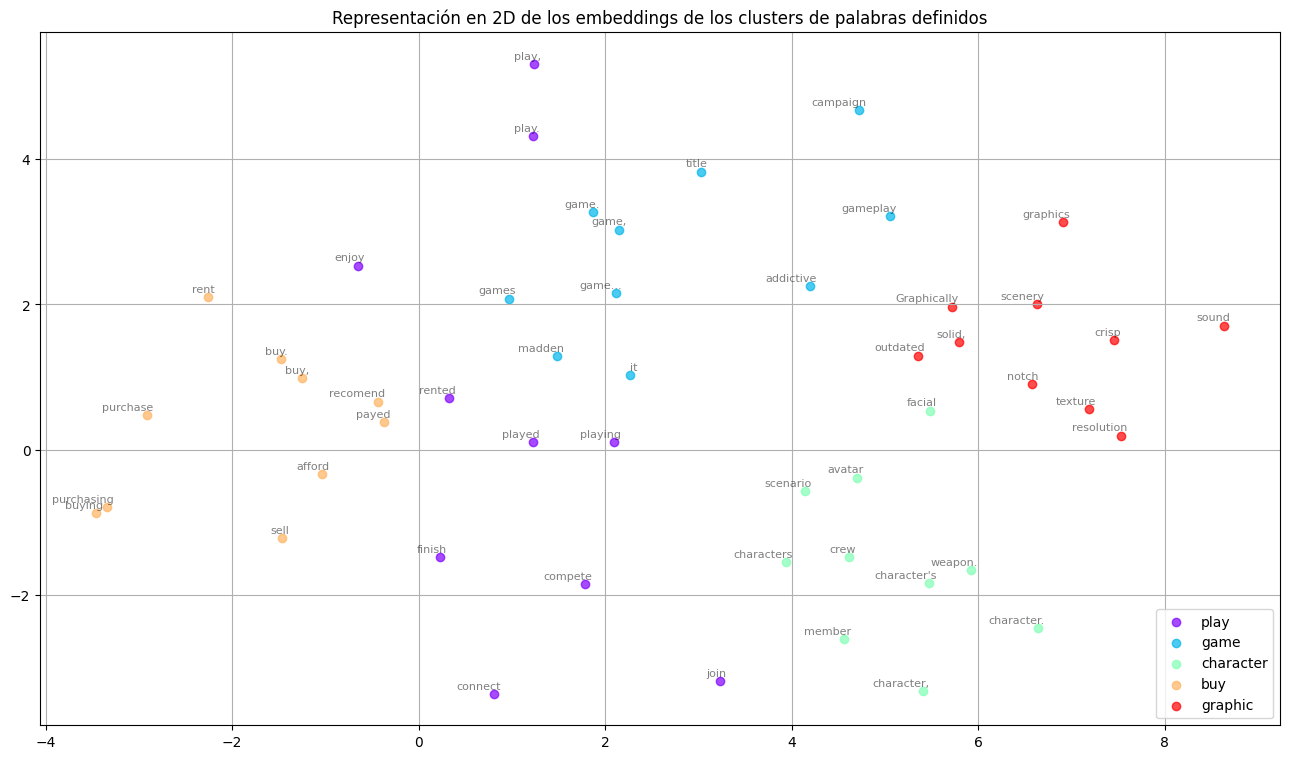

In [59]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

Conclusiones en la fase exploratoria de datos (EDA):

- Reducir el dataset original a un subset más pequeño con menos muestras, nos permite optimizar los recursos en una fase de preprocesamiento y de aplicación de modelos.

- Balancear las muestras de reviews según niveles de clasificación (overall) del usuario es fundamental para evitar el sesgo.

- Debemos realizar una buena limpieza de texto de los reviews para eliminar términos o patrones que generan ruido, asi como reducir en lo posible el vocabulario en nuestro análisis de sentimiento.

Entre los pasos de limpieza recomendados podemos mencionar:
- Convertir todo a minúsculas para normalizar los tokens y el corpus de interes.
- Eliminar espacios y caracteres especiales.
- Eliminar con Stopwords las palabras o secuencias de palabras frecuentes y palabras similares (clusters) para reducir el tamaño del vocabulario.